# Results
All graphs and results. For discussion please read associated paper.

In [2]:
# Imports for the rest of the notebook
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display, HTML
from discrete_skip_gram.util import stats_string, calc_stats
from tabulate import tabulate
if not os.path.exists('images'):
    os.mkdir('images')
def load_output(path):
    return np.load('../experiments/output/{}'.format(path))
def table(t, **kwargs):
    return HTML(tabulate(t, tablefmt='html', **kwargs))
def bar(x, data, label=None, axis=1, ax=None):
    mean = np.mean(data, axis=axis)
    std = np.std(data, axis=axis)
    if not ax:
        ax=plt
    ax.errorbar(x, mean, yerr=std, capsize=4,
                 markersize=3, fmt='-o', label=label)
def data_shapes(x):
    return {k:v.shape for k,v in x.iteritems()}
def stats_table(x, y, label, unit, axis=1):
    data = np.stack([x]+calc_stats(y, axis=axis)[0:4], axis=1)
    return table(data, headers=[label,
                                'Mean {}'.format(unit),
                                'Std','Min','Max'])
eps = 1e-9

## Cooccurrence matrix

Import precalculated cooccurrence matrix generated from Brown corpus.

Calculate marginal and conditional entropy.

In [3]:
# Load and normalize cooccurrence matrix
coo = load_output('cooccurrence.npy').astype(np.float32)
p = coo / np.sum(coo, axis=None)
print('Shape of cooccurrence matrix is {}'.format(p.shape))

Shape of cooccurrence matrix is (4946L, 4946L)


In [4]:
# Calculate marginal entropy (unigram)
marginal = np.sum(p, axis=1, keepdims=True)
marginal_nll = np.sum(marginal * -np.log(marginal+eps), axis=None) # E(x) = p(x)*log(p(x))
print('Marginal entropy is {}'.format(marginal_nll))

Marginal entropy is 5.91309642792


In [5]:
# Calculate conditional entropy (skipgram)
conditional = p / marginal
conditional_nll = np.sum(p * -np.log(conditional+eps), axis=None) # H(y|x) = p(x,y)*log(p(y|x))
print('Conditional entropy is {}'.format(conditional_nll))

Conditional entropy is 5.32560062408


## Random Baseline
Randomly cluster the vocabulary and calculate the conditional entropy of the clusters. Conditional entropy decreases as the number of clusters increases.

Cluster the vocabulary into a random binary tree and calculate the conditional entropy of each level of the tree. Conditional entropy decreases as the depth of the tree increases.

Iterations: 100


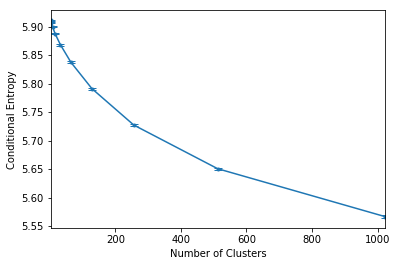

Number of Clusters,Mean Conditional Entropy,Std,Min,Max
2,5.91085,0.000417923,5.90848,5.91162
4,5.90668,0.000706,5.90458,5.90806
8,5.89952,0.000851367,5.89703,5.90156
16,5.88744,0.00110785,5.88464,5.89012
32,5.86832,0.00140799,5.86512,5.87228
64,5.83757,0.00183351,5.83401,5.84265
128,5.79137,0.00179239,5.78754,5.79692
256,5.72733,0.00182152,5.72237,5.73244
512,5.65071,0.00186907,5.64694,5.65489
1024,5.56646,0.00212267,5.56096,5.57226


In [6]:
# Random flat encodings with different numbers of clusters
random = load_output('skipgram_flat_random.npz')
print('Iterations: {}'.format(random['nlls'].shape[1]))
# Plot entropy by number of clusters
bar(random['z_ks'], random['nlls'], axis=1)
plt.ylabel('Conditional Entropy')
plt.xlabel('Number of Clusters')
plt.xlim(2, 1024)
plt.savefig('images/random.png')
plt.show()
# Tabulate entropy by number of clusters
random_2=np.mean(random['nlls'],axis=1)[0]
random_1024=np.mean(random['nlls'],axis=1)[-1]
stats_table(random['z_ks'], random['nlls'], 
            'Number of Clusters',
           'Conditional Entropy', axis=1)

Iterations: 50


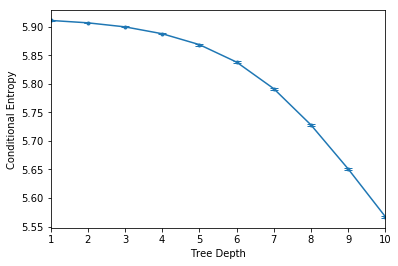

Tree Depth,Mean Conditional Entropy,Std,Min,Max
1,5.91088,0.000343061,5.90956,5.91137
2,5.9067,0.000538989,5.9054,5.90774
3,5.89963,0.000885033,5.89748,5.90151
4,5.8876,0.00130362,5.88374,5.88973
5,5.86853,0.0015739,5.86538,5.87279
6,5.83792,0.001566,5.83505,5.84269
7,5.79134,0.00177886,5.78739,5.79747
8,5.72788,0.00169426,5.72495,5.73169
9,5.65081,0.00205,5.64765,5.65527
10,5.56711,0.00207649,5.56348,5.57142


In [7]:
# Random tree encoding
tree_random = load_output('skipgram_tree_random.npz')
print('Iterations: {}'.format(tree_random['nlls'].shape[0]))
# Plot entropy by depth
bar(np.arange(1,11), tree_random['nlls'], axis=0)
plt.ylabel('Conditional Entropy')
plt.xlabel('Tree Depth')
plt.xlim(1,10)
plt.savefig('images/random_tree.png')
plt.show()
# Tabulate entropy by depth
stats_table(np.arange(1,11), tree_random['nlls'], 
            'Tree Depth',
           'Conditional Entropy', axis=0)

## Baseline Skipgram Models

Train baseline skipgram models with different numbers of hidden units (`p=softmax(xW+b)`, `loss=expected(-log(p))`).

Performance with few units approaches the analytically calculated marginal entropy.

Performance with many units approaches the calculated conditional entropy.

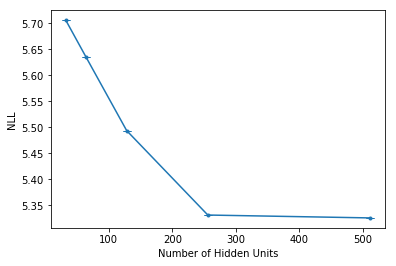

Number of Hidden Units,Mean NLL,Std,Min,Max
512,5.3256,3.69356e-07,5.3256,5.3256
256,5.33114,4.66935e-05,5.33108,5.33121
128,5.49359,9.51371e-05,5.49347,5.4937
64,5.63483,2.18327e-05,5.63479,5.63486
32,5.70584,2.80484e-06,5.70584,5.70585


In [8]:
# Vanialla baseline model
baseline = load_output('skipgram_baseline.npz')
# Plot NLL by number of hidden units
zks = baseline['z_ks']
bar(zks, baseline['nlls'], axis=1)
plt.ylabel('NLL')
plt.xlabel('Number of Hidden Units')
plt.savefig('images/baseline.png')
plt.show()
# Tabulate NLL by number of hidden units
stats_table(zks, baseline['nlls'], 
            'Number of Hidden Units',
           'NLL', axis=1)

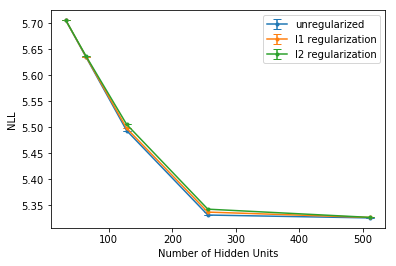

In [9]:
# Vanialla baseline model and regularization
baseline = load_output('skipgram_baseline.npz')
baselinel1 = load_output('skipgram_baseline-l1.npz')
baselinel2 = load_output('skipgram_baseline-l2.npz')
# Plot NLL by number of hidden units
zks = baseline['z_ks']
bar(zks, baseline['nlls'], 'unregularized')
bar(zks, baselinel1['nlls'], 'l1 regularization')
bar(zks, baselinel2['nlls'], 'l2 regularization')
plt.ylabel('NLL')
plt.xlabel('Number of Hidden Units')
plt.legend()
plt.savefig('images/baseline_reg.png')
plt.show()

## Binary Models

Experiments with models that cluster the vocabulary into two groups and attempt to minimize the conditional entropy of those clusters.

Proposed binary model outperformed all post-hoc clustering trials.

Average performance of post-hoc clustering underperformed random clustering in several situations.

### Proposed Binary Model

In [10]:
# Proposed binary model
binary = load_output('skipgram_binary.npz')
print('NLL: {}'.format(stats_string(binary['nlls'])))
print('Utilization: {}'.format(stats_string(binary['utilizations'])))


NLL: Mean 5.88556807427, Std 4.44760411065e-08, Min 5.88556799038, Max 5.88556810479, N 5
Utilization: Mean 2.0, Std 0.0, Min 2, Max 2, N 5


### Post-hoc Binary Clustering

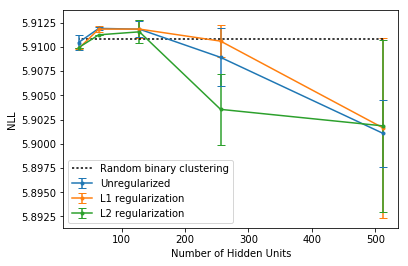

Number of Hidden Units,Mean NLL,Std,Min,Max
512,5.90108,0.0034548,5.89984,5.91303
256,5.90892,0.00300224,5.90512,5.91306
128,5.91182,0.000837471,5.91124,5.91306
64,5.9119,0.000165963,5.91185,5.91306
32,5.91045,0.000793652,5.9098,5.91305


Number of Hidden Units,Mean NLL,Std,Min,Max
512,5.90165,0.00929419,5.89243,5.91303
256,5.91059,0.00166762,5.90925,5.91304
128,5.91183,0.000912794,5.91111,5.91306
64,5.91183,0.000322674,5.91172,5.91305
32,5.90983,4.58831e-05,5.90976,5.90989


Number of Hidden Units,Mean NLL,Std,Min,Max
512,5.90185,0.00885674,5.89382,5.913
256,5.90355,0.00365792,5.90123,5.91299
128,5.91155,0.00118798,5.91051,5.91306
64,5.91124,4.18391e-06,5.91124,5.91125
32,5.90992,6.15765e-06,5.90991,5.90993


In [11]:
# GMM binary clustering
binary_gmm = load_output('skipgram_baseline_binary_gmm.npz')
# Plot NLL by baseline hidden units
bzks = binary_gmm['bzks']
bar(bzks, binary_gmm['baseline'], 'Unregularized', axis=(1,2))
bar(bzks, binary_gmm['l1'], 'L1 regularization', axis=(1,2))
bar(bzks, binary_gmm['l2'], 'L2 regularization', axis=(1,2))
plt.plot(bzks,[random_2]*bzks.shape[0], 
         label='Random binary clustering',
        linestyle='dotted',
        color='k')
plt.ylabel('NLL')
plt.xlabel('Number of Hidden Units')
plt.legend()
plt.savefig('images/binary_gmm.png')
plt.show()
display(stats_table(binary_gmm['bzks'], binary_gmm['baseline'],
           'Number of Hidden Units',
           'NLL', axis=(1,2)))
display(stats_table(binary_gmm['bzks'], binary_gmm['l1'],
           'Number of Hidden Units',
           'NLL', axis=(1,2)))
display(stats_table(binary_gmm['bzks'], binary_gmm['l2'],
           'Number of Hidden Units',
           'NLL', axis=(1,2)))

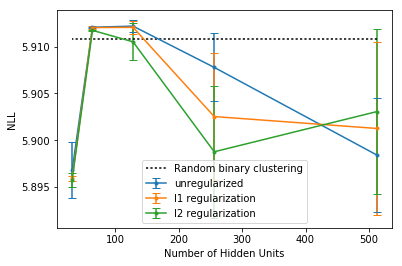

Number of Hidden Units,Mean NLL,Std,Min,Max
512,5.89844,0.0060863,5.89402,5.91306
256,5.90779,0.00364671,5.90311,5.91305
128,5.91221,0.000629088,5.91168,5.91306
64,5.91209,3.83019e-05,5.91204,5.91213
32,5.89682,0.00297384,5.89573,5.91305


Number of Hidden Units,Mean NLL,Std,Min,Max
512,5.90126,0.0092474,5.89231,5.91301
256,5.90253,0.00676673,5.89532,5.91306
128,5.91208,0.000673067,5.91157,5.91306
64,5.91205,0.000137076,5.91199,5.91305
32,5.89591,0.000277967,5.8955,5.89623


Number of Hidden Units,Mean NLL,Std,Min,Max
512,5.90305,0.00879789,5.89387,5.913
256,5.89876,0.00707608,5.89448,5.91305
128,5.91053,0.00199767,5.90769,5.91306
64,5.91175,1.67035e-05,5.91173,5.91179
32,5.89578,0.000755487,5.894,5.89658


In [12]:
# Kmeans binary clustering
binary_km = load_output('skipgram_baseline_binary_kmeans.npz')
# Plot NLL by baseline hidden units
bzks = binary_km['bzks']
bar(bzks, binary_km['baseline'], 'unregularized', axis=(1,2))
bar(bzks, binary_km['l1'], 'l1 regularization', axis=(1,2))
bar(bzks, binary_km['l2'], 'l2 regularization', axis=(1,2))
plt.plot(bzks,[random_2]*bzks.shape[0], 
         label='Random binary clustering',
        linestyle='dotted',
        color='k')
plt.ylabel('NLL')
plt.xlabel('Number of Hidden Units')
plt.legend()
plt.savefig('images/binary_km.png')
plt.show()
display(stats_table(binary_km['bzks'], binary_km['baseline'],
           'Number of Hidden Units',
           'NLL', axis=(1,2)))
display(stats_table(binary_km['bzks'], binary_km['l1'],
           'Number of Hidden Units',
           'NLL', axis=(1,2)))
display(stats_table(binary_km['bzks'], binary_km['l2'],
           'Number of Hidden Units',
           'NLL', axis=(1,2)))

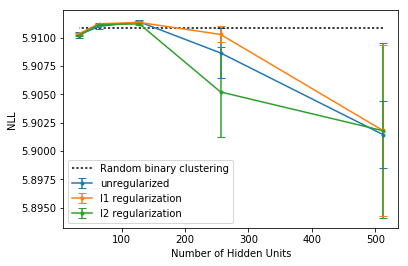

Number of Hidden Units,Mean NLL,Std,Min,Max
512,5.90108,0.0034548,5.89984,5.91303
256,5.90892,0.00300224,5.90512,5.91306
128,5.91182,0.000837471,5.91124,5.91306
64,5.9119,0.000165963,5.91185,5.91306
32,5.91045,0.000793652,5.9098,5.91305


Number of Hidden Units,Mean NLL,Std,Min,Max
512,5.90165,0.00929419,5.89243,5.91303
256,5.91059,0.00166762,5.90925,5.91304
128,5.91183,0.000912794,5.91111,5.91306
64,5.91183,0.000322674,5.91172,5.91305
32,5.90983,4.58831e-05,5.90976,5.90989


Number of Hidden Units,Mean NLL,Std,Min,Max
512,5.90185,0.00885674,5.89382,5.913
256,5.90355,0.00365792,5.90123,5.91299
128,5.91155,0.00118798,5.91051,5.91306
64,5.91124,4.18391e-06,5.91124,5.91125
32,5.90992,6.15765e-06,5.90991,5.90993


In [22]:
# GMM balanced binary clustering
binary_bgmm = load_output('skipgram_baseline_binary_bgmm.npz')
# Plot NLL by baseline hidden units
bzks = binary_bgmm['bzks']
bar(bzks, binary_bgmm['baseline'], 'unregularized', axis=(1,2))
bar(bzks, binary_bgmm['l1'], 'l1 regularization', axis=(1,2))
bar(bzks, binary_bgmm['l2'], 'l2 regularization', axis=(1,2))
plt.plot(bzks,[random_2]*bzks.shape[0], 
         label='Random binary clustering',
        linestyle='dotted',
        color='k')
plt.ylabel('NLL')
plt.xlabel('Number of Hidden Units')
plt.legend()
plt.savefig('images/binary_bgmm.png')
plt.show()
display(stats_table(binary_bgmm['bzks'], binary_gmm['baseline'],
           'Number of Hidden Units',
           'NLL', axis=(1,2)))
display(stats_table(binary_bgmm['bzks'], binary_gmm['l1'],
           'Number of Hidden Units',
           'NLL', axis=(1,2)))
display(stats_table(binary_bgmm['bzks'], binary_gmm['l2'],
           'Number of Hidden Units',
           'NLL', axis=(1,2)))

## Flat Models (k=256)

In [6]:
# Flat model without regularization
flat2 = load_output('skipgram_256.npz')
print("256 NLL: {}".format(stats_string(flat['nlls'])))
print("256 Utilization: {}".format(stats_string(flat['utilizations'])))

256 NLL: Mean 5.67888450796, Std 0.00154133048127, Min 5.67694731243, Max 5.68077087082, N 5
256 Utilization: Mean 220.2, Std 2.03960780544, Min 218, Max 223, N 5


In [8]:

pr2 = load_output('point_replace_256.npy')
print("256 PR NLL: {}".format(stats_string(pr2)))


256 PR NLL: Mean 5.6459608078, Std 7.94013321865e-05, Min 5.64584112167, Max 5.64608573914, N 5


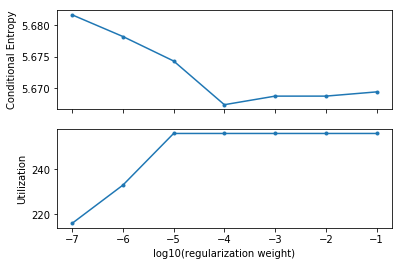

B Weight,NLL,Utilization
0.1,5.66943,256
0.01,5.66876,256
0.001,5.66876,256
0.0001,5.6674,256
1e-05,5.67433,256
1e-06,5.67822,233
1e-07,5.68166,216


In [11]:
# Flat model with balance regularizer
flat_b = load_output('skipgram_256-b.npz')
# plot NLL by regularization weight
x = np.log10(flat_b['weights'])
xlabel = 'log10(regularization weight)'
mean = np.mean(flat_b['nlls'], axis=1)
meanu = np.mean(flat_b['utilizations'], axis=1)
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)
ax1.plot(x, mean, markersize=3, marker='o', label='Conditional Entropy')
ax1.set_ylabel('Conditional Entropy')
ax2.set_xlabel(xlabel)
ax2.plot(x, meanu, markersize=3, marker='o', label='Utilization')
ax2.set_ylabel('Utilization')
plt.savefig('images/skipgram_flat_b.png')
plt.show()
# Table
t= np.stack([flat_b['weights'],mean, meanu], axis=1)
table(t, headers=['B Weight', 'NLL', 'Utilization'])

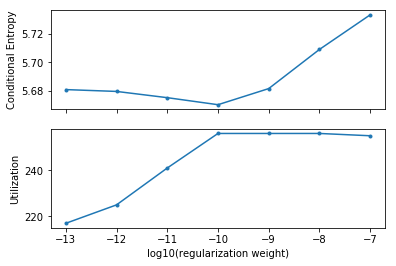

EL Weight,NLL,Utilization
1e-07,5.73324,255
1e-08,5.70909,256
1e-09,5.68175,256
1e-10,5.6705,256
1e-11,5.67541,241
1e-12,5.67977,225
1e-13,5.68106,217


In [9]:
# Flat model with exclusive lasso regularizer
flat_el = load_output('skipgram_256-el.npz')
# plot NLL by regularization weight
x = np.log10(flat_el['weights'])
xlabel = 'log10(regularization weight)'
mean = np.mean(flat_el['nlls'], axis=1)
meanu = np.mean(flat_el['utilizations'], axis=1)
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)
ax1.plot(x, mean, markersize=3, marker='o', label='Conditional Entropy')
ax1.set_ylabel('Conditional Entropy')
ax2.set_xlabel(xlabel)
ax2.plot(x, meanu, markersize=3, marker='o', label='Utilization')
ax2.set_ylabel('Utilization')
plt.savefig('images/skipgram_flat_el.png')
plt.show()
# Table
t= np.stack([flat_el['weights'],mean, meanu], axis=1)
table(t, headers=['EL Weight', 'NLL', 'Utilization'])

## Flat Models (k=1024)
Experiments with models that cluster the vocabulary into 1024 groups (`2**10`) and attempt to minimize the conditional entropy of the clusters.

Proposed model outperformed all post-hoc clustering trials.

Proposed model with regularization outperformed original model.

Average performance of post-hoc clustering underperformed random clustering in several situations.

### Proposed Clustering Models (k=1024)

In [13]:
# Flat model without regularization
flat = load_output('skipgram_flat.npz')
print("Flat NLL: {}".format(stats_string(flat['nlls'])))
print("Flat Utilization: {}".format(stats_string(flat['utilizations'])))

Flat NLL: Mean 5.5480435445, Std 0.000778813805342, Min 5.54713744241, Max 5.54945816655, N 5
Flat Utilization: Mean 809.4, Std 4.8, Min 804, Max 816, N 5


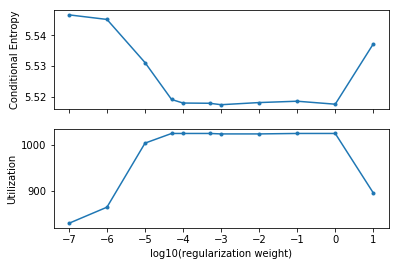

B Weight,NLL,Utilization
10,5.53717,895
1,5.51766,1024
0.1,5.51863,1024
0.01,5.5182,1023
0.001,5.5175,1023
0.0005,5.51797,1024
0.0001,5.51804,1024
5e-05,5.51919,1024
1e-05,5.53114,1003
1e-06,5.54509,864


In [14]:
# Flat model with balance regularizer
flat_b = load_output('skipgram_flat-b.npz')
# plot NLL by regularization weight
x = np.log10(flat_b['weights'])
xlabel = 'log10(regularization weight)'
mean = np.mean(flat_b['nlls'], axis=1)
meanu = np.mean(flat_b['utilizations'], axis=1)
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)
ax1.plot(x, mean, markersize=3, marker='o', label='Conditional Entropy')
ax1.set_ylabel('Conditional Entropy')
ax2.set_xlabel(xlabel)
ax2.plot(x, meanu, markersize=3, marker='o', label='Utilization')
ax2.set_ylabel('Utilization')
plt.savefig('images/skipgram_flat_b.png')
plt.show()
# Table
t= np.stack([flat_b['weights'],mean, meanu], axis=1)
table(t, headers=['B Weight', 'NLL', 'Utilization'])

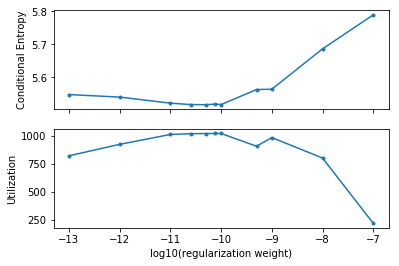

EL Weight,NLL,Utilization
1e-07,5.78906,216
1e-08,5.68598,803
1e-09,5.56357,987
5e-10,5.56253,909
1e-10,5.51713,1024
7.5e-11,5.51833,1024
5e-11,5.51661,1023
2.5e-11,5.51704,1022
1e-11,5.52134,1015
1e-12,5.53974,926


In [15]:
# Flat model with exclusive lasso regularizer
flat_el = load_output('skipgram_flat-el.npz')
# plot NLL by regularization weight
x = np.log10(flat_el['weights'])
xlabel = 'log10(regularization weight)'
mean = np.mean(flat_el['nlls'], axis=1)
meanu = np.mean(flat_el['utilizations'], axis=1)
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)
ax1.plot(x, mean, markersize=3, marker='o', label='Conditional Entropy')
ax1.set_ylabel('Conditional Entropy')
ax2.set_xlabel(xlabel)
ax2.plot(x, meanu, markersize=3, marker='o', label='Utilization')
ax2.set_ylabel('Utilization')
plt.savefig('images/skipgram_flat_el.png')
plt.show()
# Table
t= np.stack([flat_el['weights'],mean, meanu], axis=1)
table(t, headers=['EL Weight', 'NLL', 'Utilization'])

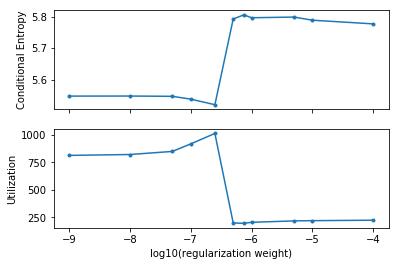

ELS Weight,NLL,Utilization
0.0001,5.77738,224
1e-05,5.78912,220
5e-06,5.79906,218
1e-06,5.79699,205
7.5e-07,5.80618,196
5e-07,5.79312,199
2.5e-07,5.51969,1011
1e-07,5.53749,916
5e-08,5.54641,848
1e-08,5.54733,820


In [16]:
# Flat model with exclusive lasso regularizer (sqrt)
flat_els = load_output('skipgram_flat-els.npz')
# plot NLL by regularization weight
x = np.log10(flat_els['weights'])
xlabel = 'log10(regularization weight)'
mean = np.mean(flat_els['nlls'], axis=1)
meanu = np.mean(flat_els['utilizations'], axis=1)
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)
ax1.plot(x, mean, markersize=3, marker='o', label='Conditional Entropy')
ax1.set_ylabel('Conditional Entropy')
ax2.set_xlabel(xlabel)
ax2.plot(x, meanu, markersize=3, marker='o', label='Utilization')
ax2.set_ylabel('Utilization')
plt.savefig('images/skipgram_flat_els.png')
plt.show()
# Table
t= np.stack([flat_els['weights'],mean, meanu], axis=1)
table(t, headers=['ELS Weight', 'NLL', 'Utilization'])

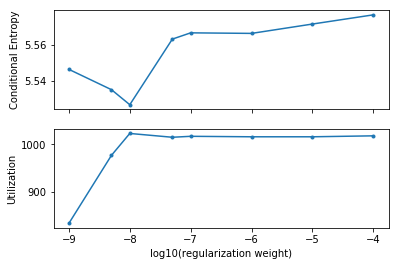

L1 Weight,NLL,Utilization
0.0001,5.57646,1018
1e-05,5.57137,1016
1e-06,5.56619,1016
1e-07,5.56649,1017
5e-08,5.56303,1015
1e-08,5.52667,1023
5e-09,5.53499,977
1e-09,5.54625,834


In [17]:
# Flat model with l1 regularizer
flat_l1 = load_output('skipgram_flat-l1.npz')
# plot NLL by regularization weight
x = np.log10(flat_l1['weights'])
xlabel = 'log10(regularization weight)'
mean = np.mean(flat_l1['nlls'], axis=1)
meanu = np.mean(flat_l1['utilizations'], axis=1)
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)
ax1.plot(x, mean, markersize=3, marker='o', label='Conditional Entropy')
ax1.set_ylabel('Conditional Entropy')
ax2.set_xlabel(xlabel)
ax2.plot(x, meanu, markersize=3, marker='o', label='Utilization')
ax2.set_ylabel('Utilization')
plt.savefig('images/skipgram_flat_l1.png')
plt.show()
# Table
t= np.stack([flat_l1['weights'],mean, meanu], axis=1)
table(t, headers=['L1 Weight', 'NLL', 'Utilization'])

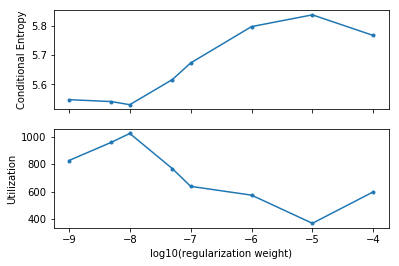

L2 Weight,NLL,Utilization
0.0001,5.76653,598
1e-05,5.83694,369
1e-06,5.79686,574
1e-07,5.67276,638
5e-08,5.61598,767
1e-08,5.53022,1023
5e-09,5.54089,959
1e-09,5.54744,826


In [18]:
# Flat model with l2 regularizer
flat_l2 = load_output('skipgram_flat-l2.npz')
# plot NLL by regularization weight
x = np.log10(flat_l2['weights'])
xlabel = 'log10(regularization weight)'
mean = np.mean(flat_l2['nlls'], axis=1)
meanu = np.mean(flat_l2['utilizations'], axis=1)
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)
ax1.plot(x, mean, markersize=3, marker='o', label='Conditional Entropy')
ax1.set_ylabel('Conditional Entropy')
ax2.set_xlabel(xlabel)
ax2.plot(x, meanu, markersize=3, marker='o', label='Utilization')
ax2.set_ylabel('Utilization')
plt.savefig('images/skipgram_flat_l2.png')
plt.show()
# Table
t= np.stack([flat_l2['weights'],mean, meanu], axis=1)
table(t, headers=['L2 Weight', 'NLL', 'Utilization'])

### Post-hoc clustering (k=1024)

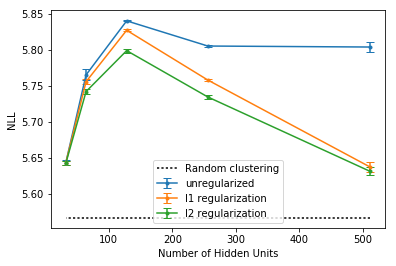

Number of Hidden Units,Mean NLL,Std,Min,Max
512,5.8042,0.00666509,5.79462,5.81402
256,5.80559,0.00139121,5.80245,5.80807
128,5.84063,0.000841765,5.83908,5.8426
64,5.76551,0.00771248,5.74984,5.77836
32,5.6432,0.00363094,5.63785,5.64948


Number of Hidden Units,Mean NLL,Std,Min,Max
512,5.63722,0.00649483,5.62689,5.6479
256,5.75826,0.00141825,5.75554,5.76029
128,5.82751,0.00149464,5.82515,5.82915
64,5.75601,0.0034133,5.75085,5.76081
32,5.64303,0.00263519,5.6382,5.64757


Number of Hidden Units,Mean NLL,Std,Min,Max
512,5.63119,0.00556723,5.62113,5.63874
256,5.73471,0.00230246,5.73169,5.73922
128,5.79919,0.00287396,5.79418,5.80326
64,5.74227,0.00354311,5.73543,5.74859
32,5.64235,0.0028155,5.63846,5.64737


In [19]:
# GMM clustering
flat_gmm = load_output('skipgram_baseline_flat_gmm.npz')
# Plot NLL by baseline hidden units
bzks = flat_gmm['bzks']
bar(bzks, flat_gmm['baseline'], 'unregularized', axis=(1,2))
bar(bzks, flat_gmm['l1'], 'l1 regularization', axis=(1,2))
bar(bzks, flat_gmm['l2'], 'l2 regularization', axis=(1,2))
plt.plot(bzks,[random_1024]*bzks.shape[0], 
         label='Random clustering',
        linestyle='dotted',
        color='k')
plt.ylabel('NLL')
plt.xlabel('Number of Hidden Units')
plt.legend()
plt.savefig('images/flat_gmm.png')
plt.show()
display(stats_table(flat_gmm['bzks'], flat_gmm['baseline'],
           'Number of Hidden Units',
           'NLL', axis=(1,2)))
display(stats_table(flat_gmm['bzks'], flat_gmm['l1'],
           'Number of Hidden Units',
           'NLL', axis=(1,2)))
display(stats_table(flat_gmm['bzks'], flat_gmm['l2'],
           'Number of Hidden Units',
           'NLL', axis=(1,2)))

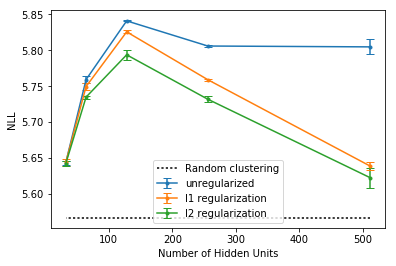

Number of Hidden Units,Mean NLL,Std,Min,Max
512,5.80479,0.010606,5.77793,5.81606
256,5.80597,0.00142725,5.80416,5.8094
128,5.84102,0.000866851,5.83856,5.84229
64,5.75925,0.0053002,5.75003,5.76769
32,5.64362,0.0027889,5.63676,5.6493


Number of Hidden Units,Mean NLL,Std,Min,Max
512,5.6387,0.0051866,5.62924,5.64478
256,5.75903,0.00161966,5.75615,5.76232
128,5.82571,0.00225665,5.82227,5.83046
64,5.74954,0.00527283,5.74208,5.75966
32,5.64373,0.00478092,5.637,5.64934


Number of Hidden Units,Mean NLL,Std,Min,Max
512,5.62251,0.0140955,5.59504,5.63322
256,5.73182,0.00436974,5.7233,5.73881
128,5.79372,0.00676037,5.7837,5.80117
64,5.73481,0.00214017,5.73118,5.7396
32,5.64221,0.00299156,5.63737,5.64804


In [20]:
# Kmeans clustering
flat_km = load_output('skipgram_baseline_flat_kmeans.npz')
# Plot NLL by baseline hidden units
bzks = flat_km['bzks']
bar(bzks, flat_km['baseline'], 'unregularized', axis=(1,2))
bar(bzks, flat_km['l1'], 'l1 regularization', axis=(1,2))
bar(bzks, flat_km['l2'], 'l2 regularization', axis=(1,2))
plt.plot(bzks,[random_1024]*bzks.shape[0], 
         label='Random clustering',
        linestyle='dotted',
        color='k')
plt.ylabel('NLL')
plt.xlabel('Number of Hidden Units')
plt.legend()
plt.savefig('images/flat_km.png')
plt.show()
display(stats_table(flat_km['bzks'], flat_km['baseline'],
           'Number of Hidden Units',
           'NLL', axis=(1,2)))
display(stats_table(flat_km['bzks'], flat_km['l1'],
           'Number of Hidden Units',
           'NLL', axis=(1,2)))
display(stats_table(flat_km['bzks'], flat_km['l2'],
           'Number of Hidden Units',
           'NLL', axis=(1,2)))

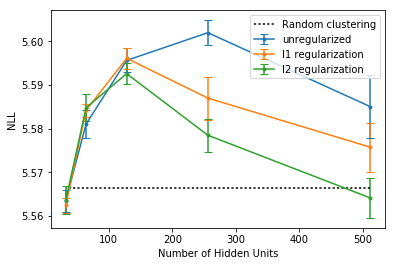

Number of Hidden Units,Mean NLL,Std,Min,Max
512,5.58504,0.00717894,5.56471,5.59787
256,5.60195,0.00285283,5.59561,5.60774
128,5.59561,0.0027491,5.59117,5.60101
64,5.58103,0.00312592,5.57539,5.58955
32,5.56349,0.00254063,5.55854,5.56912


Number of Hidden Units,Mean NLL,Std,Min,Max
512,5.57575,0.00560305,5.56441,5.58744
256,5.58699,0.00493449,5.58183,5.59827
128,5.59609,0.0024136,5.591,5.59996
64,5.5842,0.00153392,5.58129,5.58678
32,5.56243,0.00171651,5.55917,5.56566


Number of Hidden Units,Mean NLL,Std,Min,Max
512,5.56413,0.00458511,5.55813,5.5722
256,5.57848,0.00372468,5.57177,5.58372
128,5.59257,0.00233796,5.58987,5.59728
64,5.58478,0.00305017,5.57606,5.58993
32,5.56363,0.00320097,5.55841,5.5687


In [21]:
# Balanced gmm clustering
flat_bgmm = load_output('skipgram_baseline_flat_bgmm.npz')
# Plot NLL by baseline hidden units
bzks = flat_bgmm['bzks']
bar(bzks, flat_bgmm['baseline'], 'unregularized', axis=(1,2))
bar(bzks, flat_bgmm['l1'], 'l1 regularization', axis=(1,2))
bar(bzks, flat_bgmm['l2'], 'l2 regularization', axis=(1,2))
plt.plot(bzks,[random_1024]*bzks.shape[0], 
         label='Random clustering',
        linestyle='dotted',
        color='k')
plt.ylabel('NLL')
plt.xlabel('Number of Hidden Units')
plt.legend()
plt.savefig('images/flat_bgmm.png')
plt.show()
display(stats_table(flat_bgmm['bzks'], flat_bgmm['baseline'],
           'Number of Hidden Units',
           'NLL', axis=(1,2)))
display(stats_table(flat_bgmm['bzks'], flat_bgmm['l1'],
           'Number of Hidden Units',
           'NLL', axis=(1,2)))
display(stats_table(flat_bgmm['bzks'], flat_bgmm['l2'],
           'Number of Hidden Units',
           'NLL', axis=(1,2)))

## Tree Models
Experiments arranging vocabulary into a binary tree.

{'utilizations': (4L, 3L, 10L), 'betas': (4L,), 'nlls': (4L, 3L, 10L)}


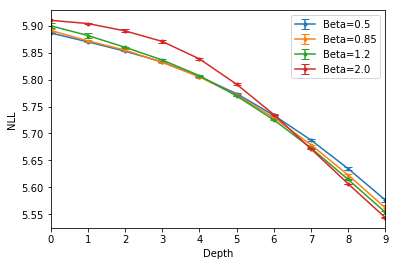

Depth,Mean NLL (Beta=0.5),Std,Min,Max
0,5.8867,2.20365e-05,5.88667,5.88672
1,5.8702,0.000578956,5.86938,5.87064
2,5.85292,5.47425e-05,5.85285,5.85298
3,5.83275,0.000897893,5.8315,5.83355
4,5.80558,0.000485411,5.80489,5.80595
5,5.77385,0.000660081,5.77293,5.77444
6,5.73379,0.000661379,5.73287,5.73439
7,5.68772,0.00159362,5.68548,5.68904
8,5.63457,0.00268317,5.6308,5.63683
9,5.57629,0.0034326,5.57149,5.57927


Depth,Mean NLL (Beta=0.85),Std,Min,Max
0,5.8914,0.00316443,5.88695,5.89403
1,5.87211,0.00161671,5.87076,5.87438
2,5.85477,0.00132591,5.85298,5.85616
3,5.8322,0.00108436,5.83078,5.83342
4,5.80512,0.0013193,5.80408,5.80698
5,5.77126,0.00136411,5.76942,5.77267
6,5.72942,0.00109841,5.72789,5.73043
7,5.67903,0.000376761,5.67863,5.67954
8,5.62271,0.00281838,5.6206,5.62669
9,5.56167,0.00516434,5.55763,5.56896


Depth,Mean NLL (Beta=1.2),Std,Min,Max
0,5.90012,0.00512324,5.89521,5.90719
1,5.88196,0.0052076,5.87645,5.88895
2,5.86014,0.00133224,5.85915,5.86202
3,5.83657,0.00108008,5.83505,5.83748
4,5.80746,0.000838969,5.80628,5.80806
5,5.76975,0.000994862,5.76844,5.77085
6,5.72525,0.000899602,5.72398,5.7259
7,5.67302,0.00131257,5.67121,5.67427
8,5.61448,0.00138258,5.61254,5.61564
9,5.55348,0.00272414,5.54962,5.55544


Depth,Mean NLL (Beta=2.0),Std,Min,Max
0,5.91023,0.000106586,5.91012,5.91037
1,5.9042,0.00113406,5.90314,5.90577
2,5.89063,0.00260442,5.88752,5.89389
3,5.87098,0.00336315,5.86643,5.87447
4,5.83857,0.00138055,5.83663,5.83976
5,5.79143,0.00143742,5.78974,5.79326
6,5.73518,0.000731689,5.73415,5.73579
7,5.67139,0.000677809,5.67044,5.67188
8,5.60643,0.000319717,5.60598,5.6067
9,5.54354,0.000450297,5.54296,5.54406


In [85]:
tree = load_output('skipgram_tree.npz')
print(data_shapes(tree))
x = np.arange(10)
for b in range(tree['betas'].shape[0]):
  bar(x, tree['nlls'][b,:,:], 'Beta={}'.format(tree['betas'][b]), axis=0)
plt.ylabel('NLL')
plt.xlabel('Depth')
plt.legend()
plt.xlim(0,9)
plt.savefig('images/skipgram_tree.png')
plt.show()
for i in range(tree['betas'].shape[0]):
  display(stats_table(np.arange(10), tree['nlls'][i,:,:],
           'Depth',
           'NLL (Beta={})'.format(tree['betas'][i]), axis=0))

{'betas': (2L,), 'utilizations': (5L, 2L, 1L, 10L), 'weights': (5L,), 'nlls': (5L, 2L, 1L, 10L)}


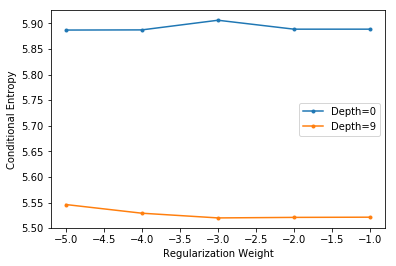

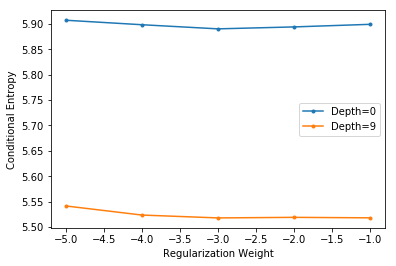

Weight (Beta=0.85),NLL0,NLL9
0.1,5.88863,5.52136
0.01,5.88861,5.52096
0.001,5.90606,5.51993
0.0001,5.88721,5.52913
1e-05,5.8869,5.54607


Weight (Beta=1.2),NLL0,NLL9
0.1,5.89922,5.51793
0.01,5.89412,5.51888
0.001,5.89029,5.51777
0.0001,5.89842,5.52343
1e-05,5.90726,5.54136


In [86]:
# Balance regularized tree
tree_b = load_output('skipgram_tree_b.npz')
print(data_shapes(tree_b))
betas = tree_b['betas']
nlls = tree_b['nlls']
weights = tree_b['weights']
x = np.log10(weights)
kws = {'markersize':3, 'marker':'o'}
for i in range(betas.shape[0]):
    idx = 0
    plt.plot(x, np.mean(tree_b['nlls'][:,i,:,idx], axis=1), label='Depth=0',**kws)
    idx = 9
    plt.plot(x, np.mean(tree_b['nlls'][:,i,:,idx], axis=1),label='Depth=9', **kws)
    plt.ylabel('Conditional Entropy')
    plt.xlabel('Regularization Weight')
    plt.legend()
    plt.savefig('images/skipgram_tree_b_{}.png'.format(i))
    plt.show()
# Tabulate data
for i in range(betas.shape[0]):
    nll0 = np.mean(nlls[:,i,:,0], axis=1)
    nll9 = np.mean(nlls[:,i,:,9], axis=1)
    t=np.stack([weights, nll0, nll9], axis=1)
    display(table(t, headers=['Weight (Beta={})'.format(betas[i]),'NLL0','NLL9']))

{'betas': (2L,), 'utilizations': (5L, 2L, 1L, 10L), 'weights': (5L,), 'nlls': (5L, 2L, 1L, 10L)}


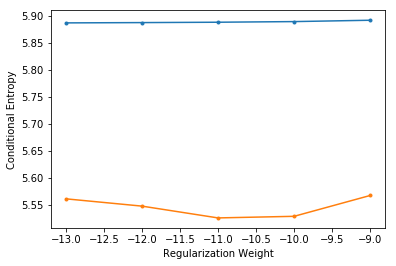

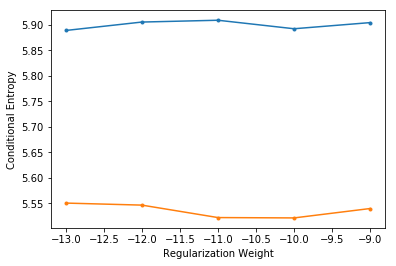

Weight (Beta=0.85),NLL0,NLL9
1e-13,5.88726,5.56094
1e-12,5.88781,5.54742
1e-11,5.88849,5.52553
1e-10,5.88966,5.52849
1e-09,5.89216,5.56714


Weight (Beta=1.2),NLL0,NLL9
1e-13,5.88864,5.55036
1e-12,5.90514,5.54637
1e-11,5.90868,5.52195
1e-10,5.89201,5.52128
1e-09,5.90406,5.53969


In [87]:
# Exclusive Lasso regularized tree
tree_el = load_output('skipgram_tree_el.npz')
print(data_shapes(tree_el))
betas = tree_el['betas']
weights=tree_el['weights']
nlls=tree_el['nlls']
x=np.log10(weights)
kws = {'markersize':3, 'marker':'o'}
for i in range(betas.shape[0]):
    nll0 = np.mean(nlls[:,i,:,0], axis=1)
    nll9 = np.mean(nlls[:,i,:,9], axis=1)
    plt.plot(x, nll0, **kws)
    plt.plot(x, nll9, **kws)
    plt.ylabel('Conditional Entropy')
    plt.xlabel('Regularization Weight')
    plt.savefig('images/skipgram_tree_el_{}.png'.format(i))
    plt.show()
plt.show()
# Tabulate data
for i in range(betas.shape[0]):
    nll0 = np.mean(nlls[:,i,:,0], axis=1)
    nll9 = np.mean(nlls[:,i,:,9], axis=1)
    t=np.stack([weights, nll0, nll9], axis=1)
    display(table(t, headers=['Weight (Beta={})'.format(betas[i]),'NLL0','NLL9']))